In [0]:
!pip3 install torch torchvision arrow itchat torchsummary bidict

In [0]:
import sys
import os

import torch
import matplotlib.pyplot as plt
print(torch.__version__)

1.0.0


In [0]:
gdrive = "/gdrive"
from google.colab import drive
drive.mount(gdrive, force_remount=True)
mydrive = os.path.join(gdrive, "My Drive")
!ls /gdrive/My\ Drive

def gpath(p):
    return os.path.join(mydrive, p)

Mounted at /gdrive
'Colab Notebooks'   data  'Hutil (1)'   models	 result   weixin.pkl


In [0]:
sys.path.append(gpath("Hutil (1)"))
import hutil

In [0]:
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset

from hutil import Vocab, pad_sequence, train_test_split, cuda, Trainer, lmap



In [0]:
MAX_LENGTH = 10

In [0]:

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


def readPairs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    with open(gpath('data/nlp_data/%s-%s.txt' % (lang1, lang2))) as f:
        lines = f.read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
    return pairs

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
    "do you", "are you",
    "i hope", "i have"
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(lang1, lang2, reverse=False):
    pairs = readPairs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    vocab1 = Vocab(tokens=["UNK", "SOS", "EOS"], name=lang2)
    vocab2 = Vocab(tokens=["UNK", "SOS", "EOS"], name=lang1)
    for pair in pairs:
        vocab1.add(pair[0].split())
        vocab2.add(pair[1].split())
    print("Counted words:")
    print(vocab1.name, vocab1.vocab_size())
    print(vocab2.name, vocab2.vocab_size())
    return vocab1, vocab2, pairs


In [0]:

SOS_token = 1
EOS_token = 2
vocab1, vocab2, pairs = prepareData('eng', 'fra', reverse=True)


def pairs_to_tensors(pairs):
    encoder_inputs = []
    decoder_inputs = []
    targets = []
    for p in pairs:
        src, dst = p
        src_tokens = src.split()
        dst_tokens = dst.split()
        encoder_inputs.append(vocab1.as_tensor(["SOS"] + src_tokens))
        decoder_inputs.append(vocab2.as_tensor(['SOS'] + dst_tokens))
        targets.append(vocab2.as_tensor(dst_tokens + ['EOS']))
    encoder_inputs = pad_sequence(
        encoder_inputs, batch_first=True, padding='pre')
    decoder_inputs = pad_sequence(
        decoder_inputs, batch_first=True, padding='post')
    targets = pad_sequence(targets, batch_first=True, padding='post')
    return encoder_inputs, decoder_inputs, targets


Reading lines...
Read 135842 sentence pairs
Trimmed to 13089 sentence pairs
Counting words...
Counted words:
fra 4927
eng 3246


In [0]:
EMBEDDING_DIM = 150
hidden_size = 128

In [0]:
x1, x2, y = pairs_to_tensors(pairs)
x1_len = x1.size(1)
dataset = TensorDataset(x1, x2, y)
train_dataset, test_dataset = train_test_split(dataset, 0.3)
test_dataset, val_dataset = train_test_split(test_dataset, 0.3)


In [0]:

class Encoder(nn.Module):
    r"""
    Inputs: x
        - **x** of shape `(batch, seq_len, input_size)`
    Outputs: out, h_n
        - **out** of shape `(batch, seq_len, num_directions * hidden_size)`
        - **h_n** of shape `(num_layers * num_directions, batch, hidden_size)`
    """

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, EMBEDDING_DIM)
        self.rnn = nn.GRU(EMBEDDING_DIM, hidden_size,
                          bidirectional=True, batch_first=True)

    def forward(self, x):
        out = self.embedding(x)
        out, h = self.rnn(out)
        return out, h


class Decoder(nn.Module):
    r"""
    Inputs: x, h
        - **x** of shape `(batch, seq_len)`: teacher-forcing word indexes with post padding
        - **h** of shape `(1, batch, hidden_size)`: context from encoder
    Outputs: outs
        - **outs** of shape `(batch, seq_len, output_size)`
    """

    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, EMBEDDING_DIM)
        self.dropout = nn.Dropout(p=0.1)
        self.rnn = nn.GRU(EMBEDDING_DIM, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h, teacher_forcing_ratio=0.5):
        batch_size, seq_len = x.shape
        outs = h.new_empty(batch_size, seq_len, self.hidden_size)
        if random.random() < teacher_forcing_ratio:
            x = self.embedding(x)
            x = self.dropout(x)
            for i in range(seq_len):
                out, h = self.rnn(x[:, [i]], h)

                outs[:, i] = out[:, 0]
        else:
            x = x.new_full((batch_size, 1), SOS_token)
            for i in range(seq_len):
                x = self.embedding(x)
                x = self.dropout(x)
                out, h = self.rnn(x, h)

                outs[:, i] = out[:, 0]
                out = self.fc(out.detach())
                topv, topi = out.topk(1)
                x = topi.squeeze(1)
        outs = self.fc(outs)
        return outs


class AttnDecoder(nn.Module):
    r"""
    Inputs: x, h
        - **x** of shape `(batch, seq_len)`: teacher-forcing word indexes with post padding
        - **h** of shape `(1, batch, hidden_size)`: context from encoder
    Outputs: outs
        - **outs** of shape `(batch, seq_len, output_size)`
    """

    def __init__(self, hidden_size, output_size, max_len, teacher_forcing_ratio=0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.embedding = nn.Embedding(output_size, EMBEDDING_DIM)
        self.dropout = nn.Dropout(p=0.1)
        self.attn = nn.Linear(hidden_size + EMBEDDING_DIM, max_len)
        self.attn_combine = nn.Linear(
            hidden_size + EMBEDDING_DIM, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def apply_attention(self, x, h, encoder_outputs, return_weights=False):
        attn_weights = self.attn(
            torch.cat((x, h.transpose(0, 1)), dim=2))
        attn_weights = torch.softmax(attn_weights, dim=2)
        attn_applied = torch.bmm(attn_weights, encoder_outputs)
        out = torch.cat((attn_applied, x), dim=2)
        out = self.attn_combine(out)
        out = torch.relu(out)
        if return_weights:
            return out, attn_weights
        else:
            return out

    def forward(self, x, h, encoder_outputs):
        batch_size, seq_len = x.shape
        outs = h.new_empty(batch_size, seq_len, self.hidden_size)

        if random.random() < self.teacher_forcing_ratio:
            x = self.embedding(x)
            x = self.dropout(x)
            for i in range(seq_len):
                out = self.apply_attention(x[:, [i]], h, encoder_outputs)
                out, h = self.rnn(out, h)

                outs[:, i] = out[:, 0]
        else:
            x = x.new_full((batch_size, 1), SOS_token)
            for i in range(seq_len):
                x = self.embedding(x)
                x = self.dropout(x)
                out = self.apply_attention(x, h, encoder_outputs)
                out, h = self.rnn(out, h)

                outs[:, i] = out[:, 0]

                out = self.fc(out.detach())
                topv, topi = out.topk(1)
                x = topi.squeeze(1)
        outs = self.fc(outs)
        return outs


class Translator(nn.Module):
    r"""
    Inputs: x1, x2
        - **x1** of shape `(batch, seq_len)`: encoder input
        - **x2** of shape `(batch, seq_len)`: decoder input used for teacher forcing
    Outpus: outs
        _ **outs** of shape `(batch, seq_len, output_size)`
    """

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = AttnDecoder(hidden_size * 2, output_size, MAX_LENGTH)

    def forward(self, x1, x2):
        encoder_outputs, _ = self.encoder(x1)
        h = encoder_outputs[:, [-1]].transpose(0, 1)
        outs = self.decoder(x2, h, encoder_outputs)
        outs.transpose_(1, 2)
        return outs



In [0]:

net = Translator(vocab1.vocab_size(), hidden_size, vocab2.vocab_size())
net = cuda(net)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001)
lr_scheduler = LambdaLR(optimizer, lambda x: 0.96 ** x)
trainer = Trainer(net, criterion, optimizer, lr_scheduler)



In [0]:
trainer.fit(train_dataset, batch_size=32, epochs=10, val_dataset=val_dataset)


Epoch 1/10
Elapsed: 17s   Loss: 0.1190   Accuracy: 9.774   Val_Acc: 7.649   Val_Loss: 1.5292
Epoch 2/10
Elapsed: 17s   Loss: 0.1033   Accuracy: 9.804   Val_Acc: 7.797   Val_Loss: 1.4408
Epoch 3/10
Elapsed: 17s   Loss: 0.0894   Accuracy: 9.832   Val_Acc: 7.824   Val_Loss: 1.4440
Epoch 4/10
Elapsed: 17s   Loss: 0.0800   Accuracy: 9.847   Val_Acc: 7.714   Val_Loss: 1.5151
Epoch 5/10
Elapsed: 17s   Loss: 0.0775   Accuracy: 9.846   Val_Acc: 7.873   Val_Loss: 1.4320
Epoch 6/10
Elapsed: 17s   Loss: 0.0705   Accuracy: 9.848   Val_Acc: 7.810   Val_Loss: 1.4902
Epoch 7/10
Elapsed: 17s   Loss: 0.0626   Accuracy: 9.866   Val_Acc: 7.603   Val_Loss: 1.6265
Epoch 8/10
Elapsed: 17s   Loss: 0.0590   Accuracy: 9.866   Val_Acc: 7.801   Val_Loss: 1.4999
Epoch 9/10
Elapsed: 17s   Loss: 0.0527   Accuracy: 9.873   Val_Acc: 7.732   Val_Loss: 1.6083
Epoch 10/10
Elapsed: 17s   Loss: 0.0502   Accuracy: 9.874   Val_Acc: 7.792   Val_Loss: 1.5527


([0.1190010215243396,
  0.10329391207636857,
  0.08943986993945018,
  0.07998332268321558,
  0.07754085540044597,
  0.07052769821513619,
  0.06262119921112515,
  0.05903479323206463,
  0.05267633210854665,
  0.05021556797161543],
 [9.773982320200808,
  9.804103459565644,
  9.832369311360909,
  9.847211611917494,
  9.84622940085125,
  9.847539015606243,
  9.865764487613227,
  9.866419294990724,
  9.872530830514023,
  9.874386118083597])

In [0]:

def sample(net, sentence):
    sentence = normalizeString(sentence)
    x1 = [vocab1.as_tensor(["SOS"] + sentence.split())]
    x1 = pad_sequence(x1, batch_first=True, padding='pre', max_len=x1_len)
    encoder_outputs, _ = net.encoder(x1)
    h = encoder_outputs[:, [-1]].transpose(0, 1)
    
    max_len = x1_len
    weights = h.new_empty((max_len, max_len))
    x = h.new_tensor([[SOS_token]], dtype=torch.long)
    words = []
    for i in range(max_len):
        x = net.decoder.embedding(x)
        out, weight = net.decoder.apply_attention(x, h, encoder_outputs, return_weights=True)
        out, h = net.decoder.rnn(out, h)
        weights[i] = weight[0,0]
        x = net.decoder.fc(out)
        x = x.topk(1)[1].squeeze(1)
        index = x.item()
        word = vocab2.get_token_from_index(index)
        words.append(word)
        if index == EOS_token:
            break
    return words, weights


def beam_search_sample(net, sentence, beam_width=3):
    sentence = normalizeString(sentence)
    x1 = [vocab1.as_tensor(["SOS"] + sentence.split())]
    x1 = pad_sequence(x1, batch_first=True, padding='pre', max_len=x1_len)
    encoder_outputs, _ = net.encoder(x1)
    h = encoder_outputs[:, [-1]].transpose(0, 1)

    def beam_search(x, h, beam_depth):
        x = net.decoder.embedding(x)
        out, weights = net.decoder.apply_attention(x, h, encoder_outputs, return_weights=True)
        out, h = net.decoder.rnn(out, h)
        x = net.decoder.fc(out)
        x = F.log_softmax(x, dim=-1)

        if beam_depth == 1:
            topv, topi = x.topk(1)
            p = topv.item()
            x = topi.squeeze(1)
            return [x], [h], p
        else:
            topv, topi = x.topk(beam_width)
            topv.squeeze_(1)
            x = topi.squeeze(1)
            xs = []
            hs = []
            for i in range(beam_width):
                xb = x[:, [i]]
                x_acc, h_acc, p = beam_search(xb, h, beam_depth-1)
                xs.append([xb] + x_acc)
                hs.append([h] + h_acc)
                topv[0, i] += p
            mv, mi = topv.topk(1)
            mi = mi.item()
            p = mv.item()
            return xs[mi], hs[mi], mv.item()

    max_len = x1_len
    x = h.new_tensor([[SOS_token]], dtype=torch.long)
    words = []
    li = 0
    while li < max_len:
        li_beam_width = min(beam_width, max_len - li)
        x_acc, h_acc, _ = beam_search(x, h, li_beam_width)
        for i in range(li_beam_width):
            index = x_acc[i].item()
            word = vocab2.get_token_from_index(index)
            words.append(word)
            if index == EOS_token:
                return words
        x = x_acc[-1]
        h = h_acc[-1]
        li += li_beam_width


['he', 'is', 'not', 'at', 'all', 'all', '.', 'EOS']
['he', 'is', 'not', 'at', 'all', 'all', '.', 'EOS']


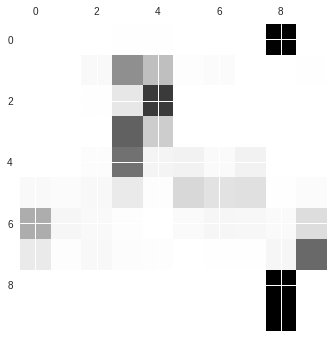

In [0]:
sentence = "Il n'est pas honnête du tout."
words, weights = sample(net, sentence)
print(words)
plt.matshow(weights.detach().cpu().numpy())
print(beam_search_sample(net, sentence, beam_width=3))

In [0]:
def tensor_to_words(tensor):
    return lmap(lambda l: lmap(vocab2.get_token_from_index, l), tensor.tolist())

In [0]:
from torch.utils.data import DataLoader

data_loader = DataLoader(val_dataset, batch_size=3, shuffle=True)
batch = data_loader.__iter__().next()
*batch_x, batch_y = batch
batch_x = [ cuda(x) for x in batch_x ]
batch_y = cuda(batch_y)

output = net(*batch_x)
loss = criterion(output, batch_y)
print(loss.item())

print(tensor_to_words(output.argmax(1)))
print(tensor_to_words(batch_y))

1.8249590396881104
[['i', 'm', 'not', 'proud', 'of', 'that', '.', 'EOS', 'UNK', 'UNK'], ['i', 'm', 'happy', 'happy', '.', '.', 'EOS', 'UNK', 'UNK', 'UNK'], ['she', 'is', 'the', '.', 'EOS', '.', 'EOS', 'UNK', 'UNK', 'UNK']]
[['i', 'am', 'not', 'proud', 'of', 'this', '.', 'EOS', 'UNK', 'UNK'], ['i', 'm', 'kind', 'of', 'happy', '.', 'EOS', 'UNK', 'UNK', 'UNK'], ['she', 's', 'upset', 'right', 'now', '.', 'EOS', 'UNK', 'UNK', 'UNK']]
